# Multiple Linear Regression using RFE

In [155]:
#Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [131]:
#File variables
housing_csv = "data/Housing.csv"

In [132]:
df = pd.read_csv(housing_csv)

## 1. Read, understand and visualising the data

In [133]:
#1. Understand the data
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## 2. Preparing the data for modeling

### a) Convert the non-numerical var to numerical var
- Convert binary var to 1 and 0.
- Create dummy var for other categorical var.

In [134]:
# Convert binary var to 1 and 0.
df = pd.read_csv(housing_csv)
varlist = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
df[varlist] = df[varlist].apply(lambda x: x.map({'yes': 1, 'no': 0}))
df[varlist].head()

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea
0,1,0,0,0,1,1
1,1,0,0,0,1,0
2,1,0,1,0,0,1
3,1,0,1,0,1,1
4,1,1,1,0,1,0


Note:
- Here we can drop one column and use only 2 columns.
- 00 for furn, 01 for unfurn, and 10 for semi-furn.

In [135]:
status = pd.get_dummies(df['furnishingstatus'], drop_first=True)
status.head()

,semi-furnished,unfurnished
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0


In [136]:
#concat with original df and drop old furnishingstatus var.
df = df.drop('furnishingstatus', axis=1)
df = pd.concat([df, status], axis=1)

Note: 
All the data converted into numeric values.

### b) Split into train and test data sets

In [137]:
from sklearn.model_selection import train_test_split

In [138]:
df_train, df_test = train_test_split(df, train_size=0.7, random_state=100)

### c) Rescalling

In [139]:
from sklearn.preprocessing import MinMaxScaler

In [140]:
scaler = MinMaxScaler()

In [141]:
#Rescale the numerical variable.
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']

In [142]:
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

### d) Divide data

In [143]:
#Data sets
y_train = df_train.pop('price')
x_train = df_train

## 3. Train the Model using RFE

In [144]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [145]:
#Fit the model
lm = LinearRegression()
lm.fit(x_train, y_train)

LinearRegression()

In [146]:
#Run RFE with the output number of the variable = 10
rfe = RFE(lm)
rfe = rfe.fit(x_train, y_train)

In [147]:
list(zip(x_train.columns, rfe.support_, rfe.ranking_))

[('area', True, 1),
 ('bedrooms', False, 2),
 ('bathrooms', True, 1),
 ('stories', True, 1),
 ('mainroad', False, 3),
 ('guestroom', False, 5),
 ('basement', False, 7),
 ('hotwaterheating', True, 1),
 ('airconditioning', True, 1),
 ('parking', False, 4),
 ('prefarea', True, 1),
 ('semi-furnished', False, 8),
 ('unfurnished', False, 6)]

In [148]:
col = x_train.columns[rfe.support_]
col

Index(['area', 'bathrooms', 'stories', 'hotwaterheating', 'airconditioning',
       'prefarea'],
      dtype='object')

In [149]:
x_train.columns[~rfe.support_]

Index(['bedrooms', 'mainroad', 'guestroom', 'basement', 'parking',
       'semi-furnished', 'unfurnished'],
      dtype='object')

In [150]:
#Build model
x_train_rfe = x_train[col]

In [151]:
#Add const
import statsmodels.api as sm
x_train_rfe = sm.add_constant(x_train_rfe)

In [152]:
#Run linear regression
lm = sm.OLS(y_train, x_train_rfe).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     106.7
Date:                Mon, 05 Sep 2022   Prob (F-statistic):           6.98e-78
Time:                        20:26:47   Log-Likelihood:                 353.86
No. Observations:                 381   AIC:                            -693.7
Df Residuals:                     374   BIC:                            -666.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0659      0.010      6.473      0.000       0.046       0.086
area                0.3085      0.029     10.537      0.000       0.251       0.366
bathrooms           0.2152      0.022      9.565      0.000       0.171       0.259
stories             0.1133      0.018      6.271      0.000       0.078       0.149
hotwaterheating     0.0995      0.023      4.359      0.000       0.055       0.144
airconditioning     0.0774      0.012      6.556      0.000       0.054       0.101
prefarea            0.0736      0.012      6.017      0.000       0.050       0.098
==============================================================================
Omnibus:                       92.802   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              318.088
Skew:                           1.061   Prob(JB):                     8.47e-70
Kurtosis:                       6.941   Cond. No.                         7.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Residual Analysis

In [153]:
y_train_pred = lm.predict(x_train_rfe)

/Users/ramesh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

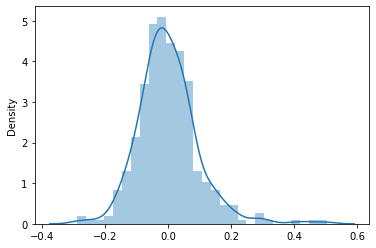

In [154]:
res = y_train - y_train_pred
sns.distplot(res)